In [4]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

import os, sys
from time import time

from pathlib import Path
import numpy as np
import pandas as pd
import pandas_datareader.data as web

import statsmodels.api as sm
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import scale
import lightgbm as lgb
from scipy.stats import spearmanr
from tqdm import tqdm
import shap

import matplotlib.pyplot as plt
import seaborn as sns


In [7]:
from datetime import datetime, timedelta

import talib

from tumbler.constant import Interval
from tumbler.service.mysql_service import MysqlService
from tumbler.object import BarData, FactorData

use_start_time = datetime(2017, 1, 1)
use_end_time = datetime.now() + timedelta(hours=10)


def create_df(suffix="_usdt"):
    global use_start_time, use_end_time
    mysql_service_manager = MysqlService.get_mysql_service()
    symbols = mysql_service_manager.get_mysql_distinct_symbol(table=MysqlService.get_kline_table(Interval.DAY.value))
    symbols = [x for x in symbols if
                   x.endswith(suffix) and not x.endswith("down_usdt")
                   and not x.endswith("up_usdt") and not x.endswith("bear_usdt") 
                   and not x in ["drep_usdt", "cocos_usdt"]]
    bars = mysql_service_manager.get_bars(symbols=[], period=Interval.DAY.value,
                                          start_datetime=use_start_time,
                                          end_datetime=use_end_time,
                                          sort_way="symbol")

    bars = BarData.suffix_filter(bars, suffix="_usdt")
    bars.sort()

    pd_data = BarData.get_pandas_from_bars(bars)
    pd_data = pd_data.set_index(["symbol", "datetime"]).sort_index().reset_index()
    
    return pd_data


def merge_factor(df, factor_codes):
    global use_start_time, use_end_time
    if isinstance(factor_codes, str):
        factor_codes = [factor_codes]
    mysql_service_manager = MysqlService.get_mysql_service()
    factor_ret = mysql_service_manager.get_factors(
        factor_codes=factor_codes,
        interval=Interval.DAY.value,
        start_dt=use_start_time,
        end_dt=use_end_time
    )
    for factor_code in factor_codes:
        print(factor_code)
        factor_df = FactorData.get_factor_df(factor_ret, factor_code)
        df = pd.merge(df, factor_df, how='left', left_on=['symbol', 'datetime'], right_on=['symbol', 'datetime'])

#         rank_code = f"rank_{factor_code}"
#         df[rank_code] = df.groupby(by=['datetime']).apply(
#             lambda x: pd.DataFrame(pd.qcut(df[factor_code], [0, 0.2, 0.4, 0.6, 0.8, 1.0]
#                                            , labels=[rank_code + "_1", rank_code + "_2",
#                                                      rank_code + "_3", rank_code + "_4",
#                                                      rank_code + "_5"
#                                                      ]), index=x.index))
        
    return df
    
    
def make_feature(df):
    factor_codes = []
    factor_codes += ["DROC5", "DROC10", "DROC20", "DROC30", "DROC60", "DROC90"]
    factor_codes += ["ER10", "ER20", "ER30", "ER60", "ER90", "ER120"]
    factor_codes += ["DER10", "DER20", "DER30", "DER60", "DER90", "DER120"]
    factor_codes += ["ROC1", "ROC3", "ROC5", "ROC10", "ROC20", "ROC30", "ROC60", "ROC90"]
    factor_codes += ["SIZE"]
    factor_codes += ["BOLL_UPPER", "BOLL_MIDDLE", "BOLL_LOWER"]
    factor_codes += ["MACD", "MACDSIGNAL", "MACDHIST"]
    factor_codes += ["MA5", "MA10", "MA20", "MA30", "MA60", "MA120"]
    factor_codes += ["NATR", "NEGNATR", "PPO", "MOM", "WMA", "HT_TRENDLINE", "EMA", "CCI", "CMO"]
    factor_codes += ["ADOSC", "ADX", "WILLR", "RSI14", "TRIX14", "SAR", "AROON_UP", "AROON_DOWN"]
    factor_codes += ["BOP", "SLOWD", "ULTOSC", "AD", "OBV", "ATR"]

    df = merge_factor(df, factor_codes)
    return df


def get_factor_codes():
    mysql_service = MysqlService()
    conn = mysql_service.get_conn()
    sqll = "select distinct factor_code from factor_1day"
    cur = conn.cursor()
    cur.execute(sqll)

    my_result = cur.fetchall()
    factor_codes = [x[0] for x in my_result]
    
    cur.close()
    conn.close()
    return factor_codes


# def make_feature(df):
#     factor_codes = get_factor_codes()
    
#     df = merge_factor(df, factor_codes)
#     return df


def make_target(df, num_day_rise=1):
    df["target"] = df.groupby(by=['symbol']).apply(
        lambda x: pd.DataFrame(pd.Series(talib.ROC(x.close, num_day_rise)).shift(-1 * num_day_rise), index=x.index)
    )
    return df


def split_train_test(df, split_datetime=datetime(2021, 5, 1)):
    train_df = df[df.datetime <= split_datetime].copy()
    test_df = df[df.datetime > split_datetime].copy()
    
    return train_df, test_df


In [8]:
df = create_df()
print(df)
df = make_feature(df)
print(df)

df.to_csv("df_predict_work.csv")

df = make_target(df, num_day_rise=5)
df.to_csv("df_predict_work_target_df.csv")
print(df)

df=df.dropna(axis=0,how='any')

train, test = split_train_test(df)
train.to_csv("train.csv")
test.to_csv("test.csv")


            symbol            datetime exchange    open    high     low  \
0       1inch_usdt 2020-12-25 08:00:00  BINANCE  0.2000  3.0885  0.2000   
1       1inch_usdt 2020-12-26 08:00:00  BINANCE  2.2958  2.4609  1.5717   
2       1inch_usdt 2020-12-27 08:00:00  BINANCE  1.5970  1.6516  1.0360   
3       1inch_usdt 2020-12-28 08:00:00  BINANCE  1.0600  1.2787  1.0353   
4       1inch_usdt 2020-12-29 08:00:00  BINANCE  1.1140  1.1166  0.7541   
...            ...                 ...      ...     ...     ...     ...   
136590    zrx_usdt 2021-10-07 08:00:00  BINANCE  1.0372  1.0419  0.9939   
136591    zrx_usdt 2021-10-08 08:00:00  BINANCE  1.0283  1.1100  1.0101   
136592    zrx_usdt 2021-10-09 08:00:00  BINANCE  1.0840  1.1194  1.0497   
136593    zrx_usdt 2021-10-10 08:00:00  BINANCE  1.1171  1.1288  1.0323   
136594    zrx_usdt 2021-10-11 08:00:00  BINANCE  1.0451  1.0768  1.0272   

         close        volume  
0       2.2954  1.259776e+08  
1       1.5967  5.703970e+07  
2     

Training fold 1


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's rmse: 1.83885e-18	training's RMSPE: nan	valid_1's rmse: 1.87876e-18	valid_1's RMSPE: nan
Training fold 2
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's rmse: 1.88468e-18	training's RMSPE: nan	valid_1's rmse: 1.71458e-18	valid_1's RMSPE: nan
Training fold 3
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's rmse: 1.90891e-18	training's RMSPE: nan	valid_1's rmse: 1.64708e-18	valid_1's RMSPE: nan
Training fold 4
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's rmse: 1.7962e-18	training's RMSPE: nan	valid_1's rmse: 2.10112e-18	valid_1's RMSPE: nan
Training fold 5
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's rmse: 1.81185e-18	training

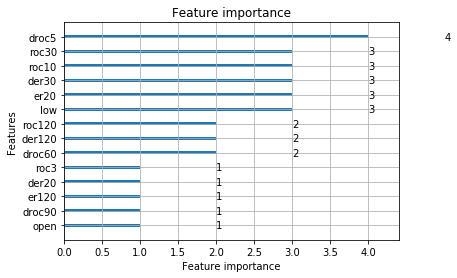

In [43]:

from sklearn.model_selection import KFold
import lightgbm as lgb

seed0 = 2021
params0 = {
    'objective': 'rmse',
    'boosting_type': 'gbdt',
    'max_depth': -1,
    'max_bin': 100,
    'min_data_in_leaf': 500,
    'learning_rate': 0.05,
    'subsample': 0.72,
    'subsample_freq': 4,
    'feature_fraction': 0.5,
    'lambda_l1': 0.5,
    'lambda_l2': 1.0,
    'categorical_column': [0],
    'seed': seed0,
    'feature_fraction_seed': seed0,
    'bagging_seed': seed0,
    'drop_seed': seed0,
    'data_random_seed': seed0,
    'n_jobs': -1,
    'verbose': -1
}
seed1 = 42


# Function to early stop with root mean squared percentage error
def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))


def feval_rmspe(y_pred, lgb_train):
    y_true = lgb_train.get_label()
    return 'RMSPE', rmspe(y_true, y_pred), False


def train_and_evaluate_lgb(train, test, params):
    features = [col for col in train.columns if col not in {"datetime", "target", "exchange", "symbol"}]
    y = train['target']
    # Create out of folds array
    oof_predictions = np.zeros(train.shape[0])
    # Create test array to store predictions
    test_predictions = np.zeros(test.shape[0])
    # Create a KFold object
    kfold = KFold(n_splits=5, random_state=2021, shuffle=True)
    # Iterate through each fold
    for fold, (trn_ind, val_ind) in enumerate(kfold.split(train)):
        print(f'Training fold {fold + 1}')
        x_train, x_val = train.iloc[trn_ind], train.iloc[val_ind]
        y_train, y_val = y.iloc[trn_ind], y.iloc[val_ind]
        # Root mean squared percentage error weights
        train_weights = 1 / np.square(y_train)
        val_weights = 1 / np.square(y_val)
        train_dataset = lgb.Dataset(x_train[features], y_train, weight=train_weights)
        val_dataset = lgb.Dataset(x_val[features], y_val, weight=val_weights)
        model = lgb.train(params=params,
                          num_boost_round=1000,
                          train_set=train_dataset,
                          valid_sets=[train_dataset, val_dataset],
                          verbose_eval=250,
                          early_stopping_rounds=50,
                          feval=feval_rmspe)
        # Add predictions to the out of folds array
        oof_predictions[val_ind] = model.predict(x_val[features])
        # Predict the test set
        test_predictions += model.predict(test[features]) / 5
    rmspe_score = rmspe(y, oof_predictions)
    print(f'Our out of folds RMSPE is {rmspe_score}')
    lgb.plot_importance(model, max_num_features=20)
    # Return test predictions
    return test_predictions


# Traing and evaluate
predictions_lgb = train_and_evaluate_lgb(train, test, params0)
test['predict_target'] = predictions_lgb


In [44]:
print(test)

            symbol            datetime exchange    open    high     low  \
127     1inch_usdt 2021-05-01 08:00:00  BINANCE  5.6389  5.7743  5.3344   
128     1inch_usdt 2021-05-02 08:00:00  BINANCE  5.5239  5.5351  5.1278   
129     1inch_usdt 2021-05-03 08:00:00  BINANCE  5.3612  5.9500  5.3525   
130     1inch_usdt 2021-05-04 08:00:00  BINANCE  5.8690  5.9084  5.2032   
131     1inch_usdt 2021-05-05 08:00:00  BINANCE  5.2431  6.2879  5.1855   
...            ...                 ...      ...     ...     ...     ...   
124928    zrx_usdt 2021-08-19 08:00:00  BINANCE  0.9673  1.0280  0.9271   
124929    zrx_usdt 2021-08-20 08:00:00  BINANCE  1.0277  1.0619  1.0068   
124930    zrx_usdt 2021-08-21 08:00:00  BINANCE  1.0577  1.0863  1.0151   
124931    zrx_usdt 2021-08-22 08:00:00  BINANCE  1.0705  1.1279  1.0450   
124932    zrx_usdt 2021-08-23 08:00:00  BINANCE  1.1221  1.1854  1.0942   

         close       volume     droc5    droc10  ...       roc3       roc5  \
127     5.5239   5663

In [30]:
test.to_csv("after_test.csv")

In [45]:
print(predictions_lgb)
print(sum(predictions_lgb))

[0. 0. 0. ... 0. 0. 0.]
0.0


In [66]:
# Function to early stop with root mean squared percentage error
def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / (y_true+0.0001))))


def feval_rmspe(y_pred, lgb_train):
    y_true = lgb_train.get_label()
    print("feval_rmspe get_label y_true:", y_true)
    print("feval_rmspe get_label y_pred:", y_pred)
    print("rmspe(y_true, y_pred):", rmspe(y_true, y_pred))
    return 'RMSPE', rmspe(y_true, y_pred), False

def train_and_evaluate_lgb(train, test, params):
    features = [col for col in train.columns if col not in {"datetime", "target", "exchange", "symbol"}]
    print(features)
    y = train['target']
    # Create out of folds array
    oof_predictions = np.zeros(train.shape[0])
    print(oof_predictions)
    # Create test array to store predictions
    test_predictions = np.zeros(test.shape[0])
    print(test_predictions)
    # Create a KFold object
    kfold = KFold(n_splits=5, random_state=2021, shuffle=True)
    # Iterate through each fold
    for fold, (trn_ind, val_ind) in enumerate(kfold.split(train)):
        print(f'Training fold {fold + 1}')
#         print(trn_ind, val_ind)
        x_train, x_val = train.iloc[trn_ind], train.iloc[val_ind]
        y_train, y_val = y.iloc[trn_ind], y.iloc[val_ind]
#         # Root mean squared percentage error weights
        train_weights = 1 / np.square(y_train)
        val_weights = 1 / np.square(y_val)
        train_dataset = lgb.Dataset(x_train[features], y_train, weight=train_weights)
        val_dataset = lgb.Dataset(x_val[features], y_val, weight=val_weights)
        model = lgb.train(params=params,
                          num_boost_round=1000,
                          train_set=train_dataset,
                          valid_sets=[train_dataset, val_dataset],
                          verbose_eval=250,
                          early_stopping_rounds=50,
                          feval=feval_rmspe)
        # Add predictions to the out of folds array
        oof_predictions[val_ind] = model.predict(x_val[features])
        print(model.predict(x_val[features]))
        
#         # Predict the test set
#         test_predictions += model.predict(test[features]) / 5
#     rmspe_score = rmspe(y, oof_predictions)
#     print(f'Our out of folds RMSPE is {rmspe_score}')
#     lgb.plot_importance(model, max_num_features=20)
#     # Return test predictions
#     return test_predictions


# Traing and evaluate
predictions_lgb = train_and_evaluate_lgb(train, test, params0)
#test['predict_target'] = predictions_lgb

['open', 'high', 'low', 'close', 'volume', 'droc5', 'droc10', 'droc20', 'droc30', 'droc60', 'droc90', 'er10', 'er20', 'er30', 'er60', 'er90', 'er120', 'der10', 'der20', 'der30', 'der60', 'der90', 'der120', 'roc1', 'roc3', 'roc5', 'roc10', 'roc20', 'roc30', 'roc60', 'roc90', 'roc120']
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
Training fold 1
feval_rmspe get_label y_true: [38.37321    41.137608   21.436422   ... 11.227536    0.24503945
  4.349032  ]
feval_rmspe get_label y_pred: [0. 0. 0. ... 0. 0. 0.]
rmspe(y_true, y_pred): 0.9985198409664174
feval_rmspe get_label y_true: [  4.8438506   6.102837  -14.572848  ... -21.133821  -16.276958
   2.1961772]
feval_rmspe get_label y_pred: [0. 0. 0. ... 0. 0. 0.]
rmspe(y_true, y_pred): 0.998582138391033
Training until validation scores don't improve for 50 rounds
feval_rmspe get_label y_true: [38.37321    41.137608   21.436422   ... 11.227536    0.24503945
  4.349032  ]
feval_rmspe get_label y_pred: [0. 0. 0. ... 0. 0. 0.]
rmspe(y_true, y_pre

rmspe(y_true, y_pred): 0.9985198409664174
feval_rmspe get_label y_true: [  4.8438506   6.102837  -14.572848  ... -21.133821  -16.276958
   2.1961772]
feval_rmspe get_label y_pred: [0. 0. 0. ... 0. 0. 0.]
rmspe(y_true, y_pred): 0.998582138391033
feval_rmspe get_label y_true: [38.37321    41.137608   21.436422   ... 11.227536    0.24503945
  4.349032  ]
feval_rmspe get_label y_pred: [0. 0. 0. ... 0. 0. 0.]
rmspe(y_true, y_pred): 0.9985198409664174
feval_rmspe get_label y_true: [  4.8438506   6.102837  -14.572848  ... -21.133821  -16.276958
   2.1961772]
feval_rmspe get_label y_pred: [0. 0. 0. ... 0. 0. 0.]
rmspe(y_true, y_pred): 0.998582138391033
feval_rmspe get_label y_true: [38.37321    41.137608   21.436422   ... 11.227536    0.24503945
  4.349032  ]
feval_rmspe get_label y_pred: [0. 0. 0. ... 0. 0. 0.]
rmspe(y_true, y_pred): 0.9985198409664174
feval_rmspe get_label y_true: [  4.8438506   6.102837  -14.572848  ... -21.133821  -16.276958
   2.1961772]
feval_rmspe get_label y_pred: [0. 

feval_rmspe get_label y_true: [  4.8438506   6.102837  -14.572848  ... -21.133821  -16.276958
   2.1961772]
feval_rmspe get_label y_pred: [0. 0. 0. ... 0. 0. 0.]
rmspe(y_true, y_pred): 0.998582138391033
feval_rmspe get_label y_true: [38.37321    41.137608   21.436422   ... 11.227536    0.24503945
  4.349032  ]
feval_rmspe get_label y_pred: [0. 0. 0. ... 0. 0. 0.]
rmspe(y_true, y_pred): 0.9985198409664174
feval_rmspe get_label y_true: [  4.8438506   6.102837  -14.572848  ... -21.133821  -16.276958
   2.1961772]
feval_rmspe get_label y_pred: [0. 0. 0. ... 0. 0. 0.]
rmspe(y_true, y_pred): 0.998582138391033
Early stopping, best iteration is:
[1]	training's rmse: 1.83885e-18	training's RMSPE: 0.99852	valid_1's rmse: 1.87876e-18	valid_1's RMSPE: 0.998582
[0. 0. 0. ... 0. 0. 0.]
Training fold 2
feval_rmspe get_label y_true: [38.37321   41.137608   4.8438506 ... 27.584394   2.1961772 11.227536 ]
feval_rmspe get_label y_pred: [0. 0. 0. ... 0. 0. 0.]
rmspe(y_true, y_pred): 0.9985913496384564
fev

feval_rmspe get_label y_true: [38.37321   41.137608   4.8438506 ... 27.584394   2.1961772 11.227536 ]
feval_rmspe get_label y_pred: [0. 0. 0. ... 0. 0. 0.]
rmspe(y_true, y_pred): 0.9985913496384564
feval_rmspe get_label y_true: [ 21.436422   -10.759158   -17.495918   ...  34.44958      0.24503945
   4.349032  ]
feval_rmspe get_label y_pred: [0. 0. 0. ... 0. 0. 0.]
rmspe(y_true, y_pred): 0.9982960703303361
feval_rmspe get_label y_true: [38.37321   41.137608   4.8438506 ... 27.584394   2.1961772 11.227536 ]
feval_rmspe get_label y_pred: [0. 0. 0. ... 0. 0. 0.]
rmspe(y_true, y_pred): 0.9985913496384564
feval_rmspe get_label y_true: [ 21.436422   -10.759158   -17.495918   ...  34.44958      0.24503945
   4.349032  ]
feval_rmspe get_label y_pred: [0. 0. 0. ... 0. 0. 0.]
rmspe(y_true, y_pred): 0.9982960703303361
feval_rmspe get_label y_true: [38.37321   41.137608   4.8438506 ... 27.584394   2.1961772 11.227536 ]
feval_rmspe get_label y_pred: [0. 0. 0. ... 0. 0. 0.]
rmspe(y_true, y_pred): 0.9

feval_rmspe get_label y_true: [38.37321   41.137608   4.8438506 ... 27.584394   2.1961772 11.227536 ]
feval_rmspe get_label y_pred: [0. 0. 0. ... 0. 0. 0.]
rmspe(y_true, y_pred): 0.9985913496384564
feval_rmspe get_label y_true: [ 21.436422   -10.759158   -17.495918   ...  34.44958      0.24503945
   4.349032  ]
feval_rmspe get_label y_pred: [0. 0. 0. ... 0. 0. 0.]
rmspe(y_true, y_pred): 0.9982960703303361
feval_rmspe get_label y_true: [38.37321   41.137608   4.8438506 ... 27.584394   2.1961772 11.227536 ]
feval_rmspe get_label y_pred: [0. 0. 0. ... 0. 0. 0.]
rmspe(y_true, y_pred): 0.9985913496384564
feval_rmspe get_label y_true: [ 21.436422   -10.759158   -17.495918   ...  34.44958      0.24503945
   4.349032  ]
feval_rmspe get_label y_pred: [0. 0. 0. ... 0. 0. 0.]
rmspe(y_true, y_pred): 0.9982960703303361
feval_rmspe get_label y_true: [38.37321   41.137608   4.8438506 ... 27.584394   2.1961772 11.227536 ]
feval_rmspe get_label y_pred: [0. 0. 0. ... 0. 0. 0.]
rmspe(y_true, y_pred): 0.9

rmspe(y_true, y_pred): 0.9986205539234941
feval_rmspe get_label y_true: [38.37321   -4.1820507 -3.194884  ... -6.9315405 22.469648  15.801248 ]
feval_rmspe get_label y_pred: [0. 0. 0. ... 0. 0. 0.]
rmspe(y_true, y_pred): 0.998179210089121
feval_rmspe get_label y_true: [41.137608   21.436422    4.8438506  ... 11.227536    0.24503945
  4.349032  ]
feval_rmspe get_label y_pred: [0. 0. 0. ... 0. 0. 0.]
rmspe(y_true, y_pred): 0.9986205539234941
feval_rmspe get_label y_true: [38.37321   -4.1820507 -3.194884  ... -6.9315405 22.469648  15.801248 ]
feval_rmspe get_label y_pred: [0. 0. 0. ... 0. 0. 0.]
rmspe(y_true, y_pred): 0.998179210089121
feval_rmspe get_label y_true: [41.137608   21.436422    4.8438506  ... 11.227536    0.24503945
  4.349032  ]
feval_rmspe get_label y_pred: [0. 0. 0. ... 0. 0. 0.]
rmspe(y_true, y_pred): 0.9986205539234941
feval_rmspe get_label y_true: [38.37321   -4.1820507 -3.194884  ... -6.9315405 22.469648  15.801248 ]
feval_rmspe get_label y_pred: [0. 0. 0. ... 0. 0. 0.

feval_rmspe get_label y_true: [38.37321    21.436422    4.8438506  ... 11.227536    0.24503945
  4.349032  ]
feval_rmspe get_label y_pred: [0. 0. 0. ... 0. 0. 0.]
rmspe(y_true, y_pred): 0.9984474271579052
feval_rmspe get_label y_true: [ 41.137608 -14.280728  -8.442717 ...  23.850094 -22.517973  27.584394]
feval_rmspe get_label y_pred: [0. 0. 0. ... 0. 0. 0.]
rmspe(y_true, y_pred): 0.9988717230630987
Training until validation scores don't improve for 50 rounds
feval_rmspe get_label y_true: [38.37321    21.436422    4.8438506  ... 11.227536    0.24503945
  4.349032  ]
feval_rmspe get_label y_pred: [0. 0. 0. ... 0. 0. 0.]
rmspe(y_true, y_pred): 0.9984474271579052
feval_rmspe get_label y_true: [ 41.137608 -14.280728  -8.442717 ...  23.850094 -22.517973  27.584394]
feval_rmspe get_label y_pred: [0. 0. 0. ... 0. 0. 0.]
rmspe(y_true, y_pred): 0.9988717230630987
feval_rmspe get_label y_true: [38.37321    21.436422    4.8438506  ... 11.227536    0.24503945
  4.349032  ]
feval_rmspe get_label y_

feval_rmspe get_label y_true: [38.37321    21.436422    4.8438506  ... 11.227536    0.24503945
  4.349032  ]
feval_rmspe get_label y_pred: [0. 0. 0. ... 0. 0. 0.]
rmspe(y_true, y_pred): 0.9984474271579052
feval_rmspe get_label y_true: [ 41.137608 -14.280728  -8.442717 ...  23.850094 -22.517973  27.584394]
feval_rmspe get_label y_pred: [0. 0. 0. ... 0. 0. 0.]
rmspe(y_true, y_pred): 0.9988717230630987
feval_rmspe get_label y_true: [38.37321    21.436422    4.8438506  ... 11.227536    0.24503945
  4.349032  ]
feval_rmspe get_label y_pred: [0. 0. 0. ... 0. 0. 0.]
rmspe(y_true, y_pred): 0.9984474271579052
feval_rmspe get_label y_true: [ 41.137608 -14.280728  -8.442717 ...  23.850094 -22.517973  27.584394]
feval_rmspe get_label y_pred: [0. 0. 0. ... 0. 0. 0.]
rmspe(y_true, y_pred): 0.9988717230630987
feval_rmspe get_label y_true: [38.37321    21.436422    4.8438506  ... 11.227536    0.24503945
  4.349032  ]
feval_rmspe get_label y_pred: [0. 0. 0. ... 0. 0. 0.]
rmspe(y_true, y_pred): 0.998447

feval_rmspe get_label y_true: [38.37321    41.137608   21.436422   ...  2.1961772   0.24503945
  4.349032  ]
feval_rmspe get_label y_pred: [0. 0. 0. ... 0. 0. 0.]
rmspe(y_true, y_pred): 0.9984823215435246
feval_rmspe get_label y_true: [  5.7073884  -2.7735837  10.56407   ... -16.092752  -21.263727
  11.227536 ]
feval_rmspe get_label y_pred: [0. 0. 0. ... 0. 0. 0.]
rmspe(y_true, y_pred): 0.9987321926263423
Training until validation scores don't improve for 50 rounds
feval_rmspe get_label y_true: [38.37321    41.137608   21.436422   ...  2.1961772   0.24503945
  4.349032  ]
feval_rmspe get_label y_pred: [0. 0. 0. ... 0. 0. 0.]
rmspe(y_true, y_pred): 0.9984823215435246
feval_rmspe get_label y_true: [  5.7073884  -2.7735837  10.56407   ... -16.092752  -21.263727
  11.227536 ]
feval_rmspe get_label y_pred: [0. 0. 0. ... 0. 0. 0.]
rmspe(y_true, y_pred): 0.9987321926263423
feval_rmspe get_label y_true: [38.37321    41.137608   21.436422   ...  2.1961772   0.24503945
  4.349032  ]
feval_rmspe 

feval_rmspe get_label y_true: [  5.7073884  -2.7735837  10.56407   ... -16.092752  -21.263727
  11.227536 ]
feval_rmspe get_label y_pred: [0. 0. 0. ... 0. 0. 0.]
rmspe(y_true, y_pred): 0.9987321926263423
feval_rmspe get_label y_true: [38.37321    41.137608   21.436422   ...  2.1961772   0.24503945
  4.349032  ]
feval_rmspe get_label y_pred: [0. 0. 0. ... 0. 0. 0.]
rmspe(y_true, y_pred): 0.9984823215435246
feval_rmspe get_label y_true: [  5.7073884  -2.7735837  10.56407   ... -16.092752  -21.263727
  11.227536 ]
feval_rmspe get_label y_pred: [0. 0. 0. ... 0. 0. 0.]
rmspe(y_true, y_pred): 0.9987321926263423
feval_rmspe get_label y_true: [38.37321    41.137608   21.436422   ...  2.1961772   0.24503945
  4.349032  ]
feval_rmspe get_label y_pred: [0. 0. 0. ... 0. 0. 0.]
rmspe(y_true, y_pred): 0.9984823215435246
feval_rmspe get_label y_true: [  5.7073884  -2.7735837  10.56407   ... -16.092752  -21.263727
  11.227536 ]
feval_rmspe get_label y_pred: [0. 0. 0. ... 0. 0. 0.]
rmspe(y_true, y_pred

[0. 0. 0. ... 0. 0. 0.]
